--- [Step 0: Installing and Importing Libraries] ---
Cloning into 'Amthal'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 76 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 1.47 MiB | 3.42 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Amthal
--- [Step 1: Loading Data] ---
Data loaded successfully. Found 4078 instances.

Identifying statistically significant concepts...
Found 3 significant concepts to analyze: ['Cognition', 'Commerce', 'Construction']
Generating the multi-panel figure...


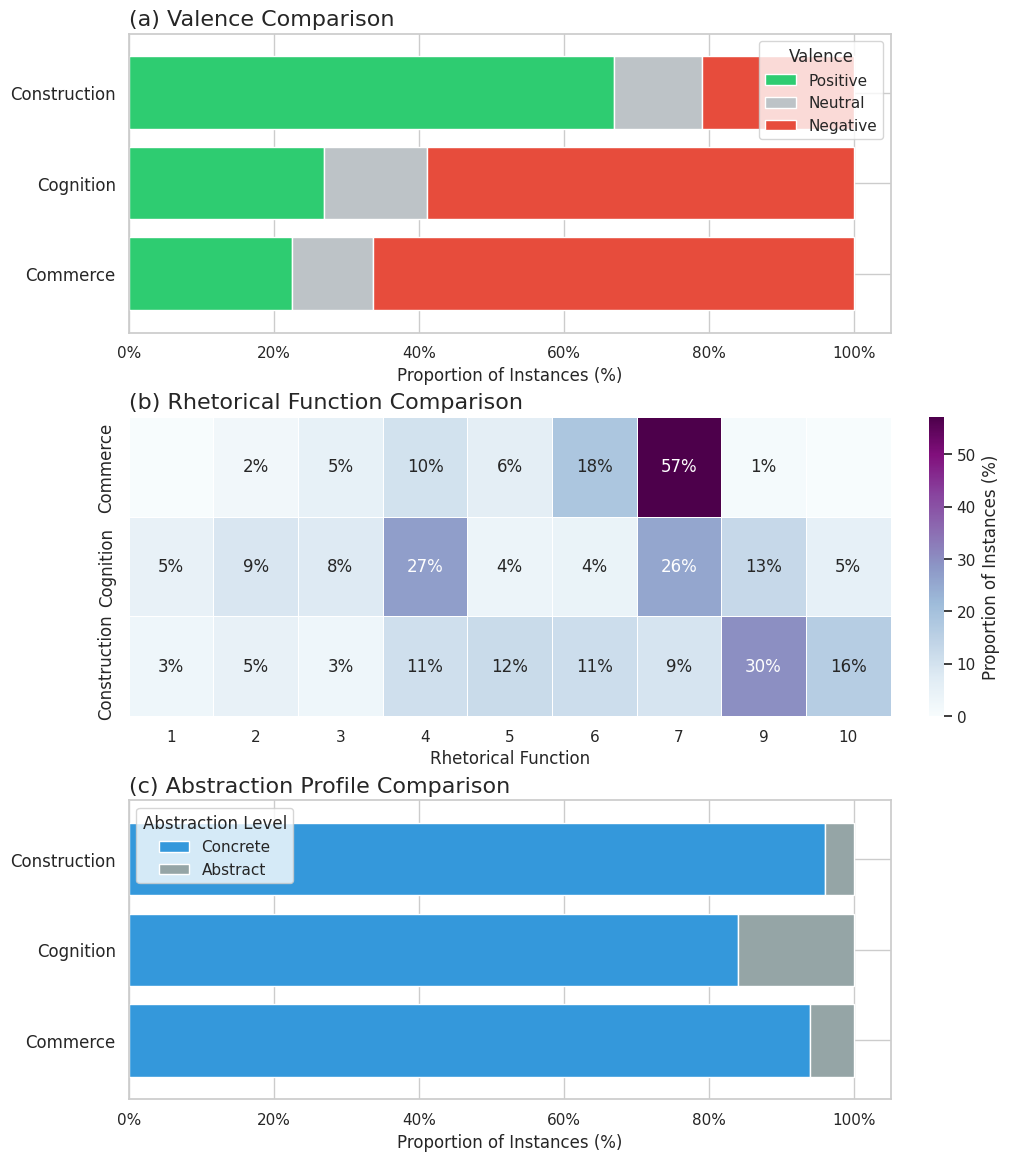

In [ ]:
#@title  **Standardized Residuals of Concepts by Period**


# --- [الخطوة 0: التثبيت والاستيراد] ---
print("--- [Step 0: Installing and Importing Libraries] ---")
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()



# (ترجمة الأعمدة التي لا تمثل فهارس رئيسية)
valence_map = {'إيجابي': 'Positive', 'سلبي': 'Negative', 'محايد': 'Neutral'}
df['Valence_En'] = df['Valence'].map(valence_map)
abs_level_map = {'محسوس': 'Concrete', 'مجرد': 'Abstract'}
df['Abstraction_Level_En'] = df['Abstraction_Level'].map(abs_level_map)


# --- 2. تحديد المفاهيم ذات الفروق الإحصائية المهمة (بالعربية) ---
print("Identifying statistically significant concepts...")
# نستخدم 'Revelation_Phase' الأصلي (العربي)
raw_counts = pd.crosstab(df['Dominant_Concept'], df['Revelation_Phase'])
chi2, p, dof, expected = chi2_contingency(raw_counts)
epsilon = 1e-9
std_residuals = (raw_counts - expected) / np.sqrt(expected + epsilon)
significant_concepts_df = std_residuals[std_residuals.abs() >= 1.96].dropna(how='all')
# >> significant_concepts_list الآن قائمة بالأسماء العربية <<
significant_concepts_list = significant_concepts_df.index.tolist()
df_sig = df[df['Dominant_Concept'].isin(significant_concepts_list)].copy()
print(f"Found {len(significant_concepts_list)} significant concepts to analyze: {significant_concepts_list}")


# --- 3. إنشاء الشكل متعدد الأجزاء ---
print("Generating the multi-panel figure...")
sns.set_theme(style="whitegrid")
fig_height = len(significant_concepts_list) * 2.5
fig, axes = plt.subplots(3, 1, figsize=(10, fig_height + 4), constrained_layout=True)
#fig.suptitle('Figure 8: Qualitative Profiles of Significantly Shifting Concepts', fontsize=20, fontweight='bold')

# --- الجزء الأول (panel a): مقارنة الشحنة (Valence) ---
ax1 = axes[0]
valence_data = pd.crosstab(df_sig['Dominant_Concept'], df_sig['Valence_En'], normalize='index') * 100
# فرز الفهرس بالأسماء العربية
sorted_concepts_ar = significant_concepts_df.abs().max(axis=1).sort_values(ascending=False).index
valence_data = valence_data.reindex(sorted_concepts_ar).dropna()
for col in ['Positive', 'Neutral', 'Negative']:
    if col not in valence_data: valence_data[col] = 0
valence_data = valence_data[['Positive', 'Neutral', 'Negative']]

valence_data.plot(kind='barh', stacked=True, color={'Positive': '#2ecc71', 'Neutral': '#bdc3c7', 'Negative': '#e74c3c'}, ax=ax1, width=0.8, edgecolor='white')
ax1.set_title('(a) Valence Comparison', fontsize=16, loc='left')
ax1.set_ylabel('')
ax1.set_xlabel('Proportion of Instances (%)')
ax1.legend(title='Valence')
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))


# --- الجزء الثاني (panel b): مقارنة الوظائف البلاغية (Rhetorical Function) ---
ax2 = axes[1]
func_data = pd.crosstab(df_sig['Dominant_Concept'], df_sig['Rhetorical_Function'], normalize='index') * 100
func_data = func_data.reindex(sorted_concepts_ar).dropna()
sns.heatmap(
    func_data, annot=True, fmt=".0f", cmap='BuPu',
    linewidths=.5, ax=ax2, cbar_kws={'label': 'Proportion of Instances (%)'}
)
ax2.set_title('(b) Rhetorical Function Comparison', fontsize=16, loc='left')
ax2.set_ylabel('')
ax2.set_xlabel('Rhetorical Function')
for t in ax2.texts:
    if float(t.get_text()) > 0: t.set_text(t.get_text() + "%")
    else: t.set_text("")


# --- الجزء الثالث (panel c): مقارنة مستوى التجريد (Abstraction Profile) ---
ax3 = axes[2]
abs_data = pd.crosstab(df_sig['Dominant_Concept'], df_sig['Abstraction_Level_En'], normalize='index') * 100
abs_data = abs_data.reindex(sorted_concepts_ar).dropna()
for col in ['Concrete', 'Abstract']:
    if col not in abs_data: abs_data[col] = 0
abs_data = abs_data[['Concrete', 'Abstract']]
abs_data.plot(kind='barh', stacked=True, color={'Concrete': '#3498db', 'Abstract': '#95a5a6'}, ax=ax3, width=0.8, edgecolor='white')
ax3.set_title('(c) Abstraction Profile Comparison', fontsize=16, loc='left')
ax3.set_ylabel('')
ax3.set_xlabel('Proportion of Instances (%)')
ax3.legend(title='Abstraction Level')
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))


# --- 4. ترجمة التسميات وتنسيق نهائي ---
# (نقوم بترجمة التسميات في كل محور على حدة في النهاية)
concept_map_ar_to_en = {
    'إدراك': 'PERCEPTION', 'بناء': 'BUILDING', 'تجارة': 'TRADE',
    'نور': 'LIGHT', 'علاقات اجتماعية': 'SOCIAL REL.' # أضف أي مفاهيم أخرى مهمة هنا
}

for ax in axes:
    # الحصول على التسميات الحالية (ستكون بالعربية)
    current_labels = [label.get_text() for label in ax.get_yticklabels()]
    # ترجمتها إلى الإنجليزية
    new_labels = [concept_map_ar_to_en.get(label, label) for label in current_labels]
    # تطبيق التسميات الجديدة
    ax.set_yticklabels(new_labels)
    ax.tick_params(axis='y', labelsize=12)


# --- 5. الحفظ والعرض ---
plt.savefig('Figure_6b_Multi_Panel_Profiles.png', dpi=300, bbox_inches='tight')
plt.show()